In [8]:
 # you only need this when running on collab
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [9]:
!pip install sacrebleu # you only need this when running on collab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 2.1 MB/s eta 0:00:00


In [10]:
!pip install rouge-score # you only need this when running on collab

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=65588eeff677bdc835954c346c2c77675e9911e8a05a926e6f4236b74470dbb4
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [11]:
from google.colab import drive
drive.mount('/content/drive')
!ls
# replace this the path to the directory containing the code
%cd drive/MyDrive/LyricGeneration/src
# verify that you are in the right directory
! ls

Mounted at /content/drive
drive  sample_data
/content/drive/MyDrive/LyricGeneration/src
final_code.ipynb   gpt2_lyrics_tokenizer  midpoint_code.ipynb		 training.ipynb
gpt2_lyrics_model  make_data.py		  numerical_features_only.ipynb


In [12]:
import pandas as pd
import numpy as np
import torch
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm  # For progress bars
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder, StandardScaler
from sacrebleu.metrics import BLEU
from sacrebleu import corpus_bleu
from nltk.translate.bleu_score import corpus_bleu
import nltk
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer

## Data Parsing and Cleaning

**Here, we are opening both the training and test dataset. Some important things that are happening to note:**

- split the data into rows and then into columns, cleaning it in the process to remove the □ block character and properly separate metadata from lyrics.

- All the categorical features (artist, title, genre, and lyrics) are put into a dataframe for categorical variables

- Everything else is put into a numerical dataframe

In [17]:
df = pd.read_csv('../datasets/final_lyrics_features_combined.csv')

df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

df_shuffled.iloc[:100].to_csv('../datasets/test_data.csv', index=False)
df_shuffled.iloc[100:].to_csv('../datasets/train_data.csv', index=False)

In [18]:
# Paths to the dataset
train_path = '../datasets/train_data.csv'
test_path = '../datasets/test_data.csv'

# Read in the CSV files
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Combine train and test data to fit the LabelEncoder
combined_df = pd.concat([train_df, test_df], axis=0)

# Define numerical and categorical columns according to your dataset structure
numerical_columns = ['popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'explicit']

# Process numerical data: Standardization
combined_df['explicit'] = combined_df['explicit'].astype(int)  # Ensure 'explicit' is integer --> true 1, false 0

# Process categorical data excluding 'Title'
categorical_columns = ['Artist', 'track_genre']

# Initialize LabelEncoder
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    combined_df[column] = le.fit_transform(combined_df[column])  # Fit and transform on combined data
    label_encoders[column] = le  # Store the encoder for potential use later


# Split combined_df back into train and test
train_df = combined_df.iloc[:train_df.shape[0]]
test_df = combined_df.iloc[train_df.shape[0]:]

# Standardize numerical data
scaler = StandardScaler()
train_numerical = scaler.fit_transform(combined_df[numerical_columns])
test_numerical = scaler.transform(combined_df[numerical_columns])


#For arnavs?
#complete_df = pd.concat([categorical_df, numerical_df], axis=1)


# Extract transformed categorical data
train_categorical = train_df[categorical_columns].values
test_categorical = test_df[categorical_columns].values

# Convert to tensors -- make sure things are the same size?
train_numerical_tensor = torch.tensor(train_numerical, dtype=torch.float32)
test_numerical_tensor = torch.tensor(test_numerical, dtype=torch.float32)

train_categorical_tensor = torch.tensor(train_categorical, dtype=torch.int64)
test_categorical_tensor = torch.tensor(test_categorical, dtype=torch.int64)

### Model and Tokenizer Setup

Standard Hugging Face Model initialization, shouldn't need to touch this

In [19]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id


# Ensure all lyrics are strings and handle NaN values
train_df['Lyrics'] = train_df['Lyrics'].fillna('').astype(str)
test_df['Lyrics'] = test_df['Lyrics'].fillna('').astype(str)

# Proceed with tokenization
#train_encodings = tokenizer(list(train_df['Lyrics'].values), truncation=True, padding=True, max_length=512, return_tensors="pt")
#test_encodings = tokenizer(list(test_df['Lyrics'].values), truncation=True, padding=True, max_length=512, return_tensors="pt")

# Tokenization
train_encodings = tokenizer(list(train_df['Lyrics'].values), truncation=True, padding='longest', return_tensors="pt")
test_encodings = tokenizer(list(test_df['Lyrics'].values), truncation=True, padding='longest', return_tensors="pt")


# The next step is to define a custom dataset that combines these elements

class LyricsDataset():
    def __init__(self, encodings, numerical_features, categorical_features):
        self.encodings = encodings
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Including numerical features
        item['numerical_features'] = self.numerical_features[idx]
        # Including categorical features
        item['categorical_features'] = self.categorical_features[idx]
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

# Initialize the datasets
train_dataset = LyricsDataset(train_encodings, train_categorical_tensor, train_numerical_tensor)
test_dataset = LyricsDataset(test_encodings, test_categorical_tensor, test_numerical_tensor)

<ipython-input-19-c20e382d0d31>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Lyrics'] = train_df['Lyrics'].fillna('').astype(str)
<ipython-input-19-c20e382d0d31>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Lyrics'] = test_df['Lyrics'].fillna('').astype(str)


In [20]:
## WITH FEATURE WEIGHTS

class WeightedLyricsDataset():
    def __init__(self, encodings, numerical_features, categorical_features, feature_weights=None):
        self.encodings = encodings
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.feature_weights = feature_weights or {}

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Applying weights to numerical features if specified
        numerical = self.numerical_features[idx].clone()
        for i, feature_name in enumerate(numerical_columns):  # Assuming numerical_columns is accessible
            if feature_name in self.feature_weights:
                numerical[i] *= self.feature_weights[feature_name]
        item['numerical_features'] = numerical
        # Including categorical features
        item['categorical_features'] = self.categorical_features[idx]
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

feature_weights = {
    'tempo': 2.0,  # Giving double weight to 'tempo'
    'valence': 1.0,  # Standard weight for 'valence'
    'popularity': 0.5,
    'danceability': 3.0,
    'energy': 1.0,
    'loudness': 2.0,
    'speechiness': 2.0,
    'acousticness': 1.0,
    'instrumentalness': 1.0,
    'liveness': 0.5,
    'valence': 1.0,
    'tempo': 2.0,
    'explicit': 1.0
}
test_dataset = WeightedLyricsDataset(test_encodings, test_numerical_tensor, test_categorical_tensor, feature_weights=feature_weights)
train_dataset = WeightedLyricsDataset(train_encodings, train_numerical_tensor, train_categorical_tensor, feature_weights=feature_weights)

In [21]:
# Initialize the tokenizer
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

# No need to add a new token, so we skip adding [PAD] and resizing embeddings

# Initialize the model
model = GPT2LMHeadModel.from_pretrained('gpt2')

# IMPORTANT: Set the model's pad_token_id to match the tokenizer's eos_token_id
model.config.pad_token_id = tokenizer.eos_token_id

# Check if the pad_token is recognized correctly
print("Pad token:", tokenizer.pad_token, "ID:", tokenizer.pad_token_id)


Pad token: <|endoftext|> ID: 50256


## Setting up the Model

Again, standard Hugging Face code, shouldn't need to touch, except for the **epochs**. ***Change this to increase/decrase run time when testing***

In [22]:

# Assuming train_dataset and test_dataset are already initialized
# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)  # Batch size can be adjusted according to your GPU memory

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Set the number of epochs
epochs = 5

# Calculate the total number of training steps
total_steps = len(train_loader) * epochs

# Initialize the scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # No warm-up
                                            num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Training Loop

This is where the training occurs. We also have everything in here like the learning rate optimizer and scheduler and all that nonsense.

We also are calculating most of the metrics in here as well. This takes quite some time to run. In my experience, one epoch takes around 1 min 30 secs ish.

In [23]:
nltk.download('punkt')

# Function to calculate ROUGE scores using the rouge-score library
def calculate_rouge_scores(hypotheses, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for hyp, ref in zip(hypotheses, references):
        score = scorer.score(ref, hyp)
        scores['rouge1'].append(score['rouge1'].fmeasure)
        scores['rouge2'].append(score['rouge2'].fmeasure)
        scores['rougeL'].append(score['rougeL'].fmeasure)

    # Calculate average scores
    avg_scores = {key: sum(values) / len(values) for key, values in scores.items()}
    return avg_scores

# Initialize lists to store metrics for plotting
train_losses, val_losses, val_bleu_scores, lr_rates, val_rouge_scores = [], [], [], [], []

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [26]:
import warnings ## supress warnings

warnings.filterwarnings("ignore", message="Setting `pad_token_id` to `eos_token_id` for open-end generation.")
warnings.filterwarnings("ignore", message="A decoder-only architecture is being used, but right-padding was detected!")

In [ ]:
# OLD VERSION -- TRY RUNNING THE ONE BELOW INSTEAD


for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Your batch will contain tokenized text along with numerical and categorical features
        # You need to adjust the model's forward method to handle these inputs
        # For this example, we will focus on the tokenized text input
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Forward pass: compute predictions and loss
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()

    # Compute the average loss
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss}")

In [24]:
## TRAINING STEP with score output

optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

for epoch in range(epochs):
    model.train()
    train_losses, lr_rates = [], []

    for batch_idx, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_losses.append(loss.item())
        lr_rates.append(scheduler.get_last_lr()[0])

    # Validation Step
    model.eval()
    val_loss, hypotheses, references = 0, [], []
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            val_loss += outputs.loss.item()

            # Generate text for BLEU and ROUGE computation
            #predictions = model.generate(input_ids, attention_mask=attention_mask, max_length=512)
            predictions = model.generate(input_ids, attention_mask=attention_mask, max_new_tokens=50)

            hyp_texts = [tokenizer.decode(g, skip_special_tokens=True) for g in predictions]
            ref_texts = [tokenizer.decode(g, skip_special_tokens=True) for g in input_ids]
            hypotheses.extend(hyp_texts)
            references.extend(ref_texts)

    avg_val_loss = val_loss / len(test_loader)
    val_bleu = corpus_bleu([[ref.split()] for ref in references], [hyp.split() for hyp in hypotheses])

    # For ROUGE, depending on the implementation, you might need to compute scores differently
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    val_rouge_scores = {key: [] for key in ['rouge1', 'rouge2', 'rougeL']}
    for hyp, ref in zip(hypotheses, references):
        scores = scorer.score(ref, hyp)
        for key in val_rouge_scores.keys():
            val_rouge_scores[key].append(scores[key].fmeasure)
    avg_rouge_scores = {key: np.mean(val) for key, val in val_rouge_scores.items()}

    print(f"Epoch {epoch+1}, Train Loss: {np.mean(train_losses)}, Validation Loss: {avg_val_loss}, Validation BLEU: {val_bleu}, Validation ROUGE: {avg_rouge_scores}")


<ipython-input-20-8a9ab79a618c>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_s

Epoch 1, Train Loss: 2.139145351720579, Validation Loss: 1.9645496240028968, Validation BLEU: 0.9632444231932721, Validation ROUGE: {'rouge1': 0.9771971224707175, 'rouge2': 0.9771440113036235, 'rougeL': 0.9771971224707175}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_i

Epoch 2, Train Loss: 1.9457132080287645, Validation Loss: 1.935548608119671, Validation BLEU: 0.9637978091100674, Validation ROUGE: {'rouge1': 0.9774157979626423, 'rouge2': 0.9773631438447455, 'rougeL': 0.9774157979626423}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_i

Epoch 3, Train Loss: 1.8929348303513094, Validation Loss: 1.9206500328504121, Validation BLEU: 0.9638955314599068, Validation ROUGE: {'rouge1': 0.9774450451840098, 'rouge2': 0.9773926797814021, 'rougeL': 0.9774450451840098}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_i

Epoch 4, Train Loss: 1.8657379773530094, Validation Loss: 1.9170551208349376, Validation BLEU: 0.9649391375756833, Validation ROUGE: {'rouge1': 0.9778384137358523, 'rouge2': 0.9777866451097387, 'rougeL': 0.9778384137358523}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_i

Epoch 5, Train Loss: 1.8428430290836277, Validation Loss: 1.9146511921515832, Validation BLEU: 0.964710655682654, Validation ROUGE: {'rouge1': 0.9777262376271011, 'rouge2': 0.9776742402554445, 'rougeL': 0.9777262376271011}


## **Saving the Model**

Very important if you just did some huge training. This code saves both the model you just trained and the tokenizer (the code needs this to decode outputted lyrics).

You can mess with the directories however you like

In [10]:
model_save_path = './gpt2_lyrics_model'
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer_save_path = './gpt2_lyrics_tokenizer'
tokenizer.save_pretrained(tokenizer_save_path)

NameError: name 'model' is not defined

## Testing

Now we open the model you just saved, and load it up for testing/lyric generation.

In [13]:
model_save_path = './gpt2_lyrics_model'
model = GPT2LMHeadModel.from_pretrained(model_save_path)
tokenizer_save_path = './gpt2_lyrics_tokenizer'
tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_save_path)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Resize the token embeddings in case new tokens were added
model.resize_token_embeddings(len(tokenizer))
# IMPORTANT: Set the model's pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id

print("Model pad_token_id:", model.config.pad_token_id)

# Make sure to move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def prepare_input(artist_name=None, prompt_text=None, numerical_features=None):
    input_text = ""

    # Convert numerical features to text
    numerical_text = ""
    if numerical_features:
        feature_names = ["popularity", "duration_ms", "explicit", "danceability", "energy", "key",
                         "loudness", "mode", "speechiness", "acousticness", "instrumentalness",
                         "liveness", "valence", "tempo", "time_signature"]
        numerical_text = " [Features] " + " ".join(f"{name}: {value}" for name, value in zip(feature_names, numerical_features))

    # Combine artist name, prompt text, and numerical features
    if artist_name:
        input_text += f"[Artist] {artist_name} "
    if prompt_text:
        input_text += f"[Prompt] {prompt_text} "
    input_text += numerical_text

    return input_text.strip()

def generate_lyrics(input_text, max_length=100):
    # Encode the combined input text
    encoded_input = tokenizer.encode(input_text, add_special_tokens=True, return_tensors="pt")
    encoded_input = encoded_input.to(device)

    # Generate an attention mask for the encoded input
    attention_mask = torch.ones(encoded_input.shape, dtype=torch.long, device=device)  # Assuming no actual padding is needed here

    # Generate a sequence of tokens following the input context
    output_sequences = model.generate(
        input_ids=encoded_input,
        attention_mask=attention_mask,
        max_length=max_length + encoded_input.size(-1),  # Adjusting max_length to accommodate the input length
        temperature=1.0,
        top_k=50,
        top_p=0.95,
        repetition_penalty=1.2,
        do_sample=True,
        num_return_sequences=1,
    )

    # Decode the generated tokens to text
    generated_sequence = output_sequences[0].tolist()
    text = tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True)

    # Optionally, remove the input text from the output to only get the generated portion
    text_without_input = text[len(input_text):].strip()

    return text_without_input

# Now, using the `prepare_input` function to generate the input text
input_text = prepare_input(artist_name="The Beatles", prompt_text="Love is all you need",
                           #numerical_features=[32, 155792, 0, 0.452, 0.268, 8, -9.405, 1, 0.0311, 0.961, 2.85e-05, 0.119, 0.265, 66.805, 4]
                           )

# Generating lyrics based on the prepared input text
generated_lyrics = generate_lyrics(input_text, max_length=100)  # Adjust max_length as needed
print(generated_lyrics)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model pad_token_id: 50256
. And if we get caught in the middle there's no getting out of it, everybody else will die that same day without us and nobody'll talk to me about your feelings at first because I am still too young for a '85 vibe on stage i guess he was just talking back before my music got stuck yeah  prelude 7 or 8 hey little hoe boy what do ya think makin' this feel like love with someone who has heard nothing but his words how can't they tell why


In [14]:
model = GPT2LMHeadModel.from_pretrained(model_save_path)
tokenizer_save_path = './gpt2_lyrics_tokenizer'
tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_save_path)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Resize the token embeddings in case new tokens were added
model.resize_token_embeddings(len(tokenizer))
# IMPORTANT: Set the model's pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id

print("Model pad_token_id:", model.config.pad_token_id)

# Make sure to move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Model pad_token_id: 50256


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

### **This is the function that generates lyrics and calls your model:**

In [15]:
def generate_lyrics(prompt_text, max_length=100):
    # Encode the prompt text
    encoded_prompt = tokenizer.encode(prompt_text, add_special_tokens=True, return_tensors="pt")
    encoded_prompt = encoded_prompt.to(device)
    attention_mask = torch.ones(encoded_prompt.shape, dtype=torch.long, device=device)  # Assuming no actual padding is needed here

    # Generate a sequence of tokens following the prompt
    output_sequences = model.generate(
        input_ids=encoded_prompt,
        attention_mask=attention_mask,
        max_length=100,
        temperature=1.0,
        top_k=50,
        top_p=0.95,
        repetition_penalty=1.2,
        do_sample=True,
        num_return_sequences=1,
    )

    # Decode the generated tokens to text
    generated_sequence = output_sequences[0].tolist()
    text = tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True)

    # Remove the prompt text from the output
    text = text[len(tokenizer.decode(encoded_prompt[0], clean_up_tokenization_spaces=True)):]

    return text.strip()


### How to Generate Lyrics

**prompt w numeric features?? need another layer just for acoustic arrays / encode better. accuracy scores are good but output is so silly**

In [19]:
prompt_text = "The world is yours, but the city's mine" ## problem for continuous generation
## end of existing lyrics just gets fucked
lyrics = generate_lyrics(prompt_text, max_length=100)
print("Generated Lyrics:\n" + lyrics)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Lyrics:
pre i'm sorry for your inconvenience my lord just keeps on getting better heh oh I've seen things with a thousand eyes don't you see? and maybe someday his days will begin like some faraway paradise where nothing truly matters if it doesn't belong to him anymore than all of our troubles we go through in this life can be forgiven or even feared that no one wants what they want instead their whole lives change every single night 'cause


In [18]:
prompt_text = "Valence: 10 popularity:10, drake" ## problem for continuous generation
## end of existing lyrics just gets fucked
lyrics = generate_lyrics(prompt_text, max_length=100)
print("Generated Lyrics:\n" + lyrics)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Lyrics:
's gold nugget<|endoftext|>


In [32]:
prompt_text = "Drake is fruity"
lyrics = generate_lyrics(prompt_text, max_length=100)
print("Generated Lyrics:\n" + lyrics)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Lyrics:
and heavy<|endoftext|>


In [33]:
prompt_text = "i hate taylor swift" ## do we have to censor this LOL
lyrics = generate_lyrics(prompt_text, max_length=100)
print("Generated Lyrics:\n" + lyrics)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Lyrics:
it's all good but how do i know a nigga that shit got me  post the most amazing thing you saw my face on saturday night just like jyana thought with those eyes and we're gone this whole time yeah so don't tell anyone she went crazy or whatever maybe he feels no sense of sadness about these things dont see us anymore 'cause then what is there to say here? hey girl they shouldnta think your momma was fake enough for someone whose name only comes


In [36]:
prompt_text = "No sé si es casualidad que yo me sienta así. Siempre que tú estás cerquita de mí"
lyrics = generate_lyrics(prompt_text, max_length=100)
print("Generated Lyrics:\n" + lyrics)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Lyrics:
rcula donde la salami a su luego sin bien pero se  prelés el vieres almerizando las puedes le ayuda en los comimos unafriendable i novez fin mi entretas y voyaje pasado por nos loi aquella chana tiestrada encontrar conna homme recondido mas cuintro mancesanar cenora hace hablin,


In [ ]:
## is pre a start token? doesn't do well for spanish/non english prompts btw (rip bad bunny)
## guys tbh should we change the whole goal of the project ot lyrics completion idk how to include acoustics anymore

# Visualization

Below is all the visualization code we had for the report. Not really important but feel free to run it.

Everything is accurate except thematic_keywords if I remember correctly, the plot isn't really working.

Thematic Keywords Found: 1 out of 11


  0%|          | 0/14 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
  7%|▋         | 1/14 [00:01<00:14,  1.12s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
 14%|█▍        | 2/14 [00:02<00:12,  1.06s/it]The attention mask and

Average Thematic Keywords Found: 1.3428571428571427


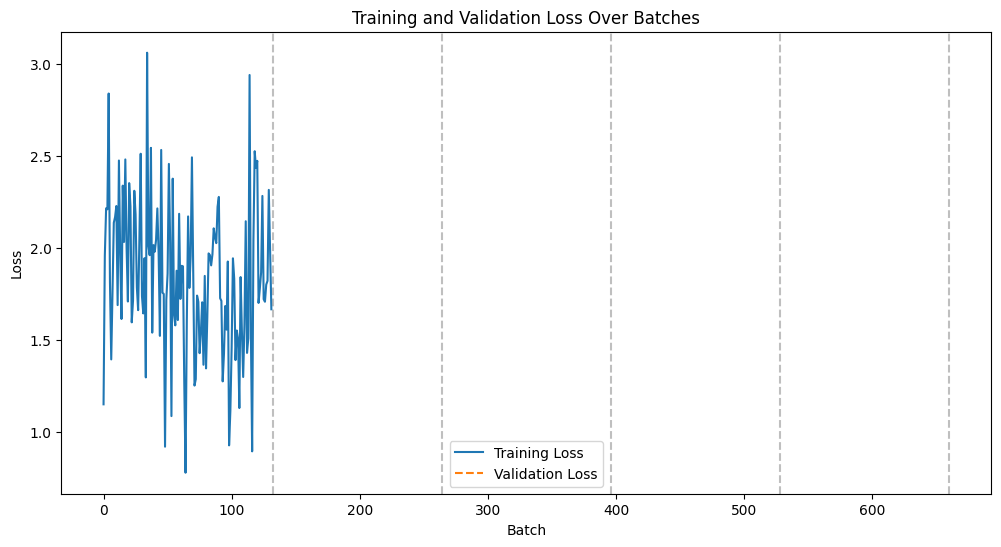

ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

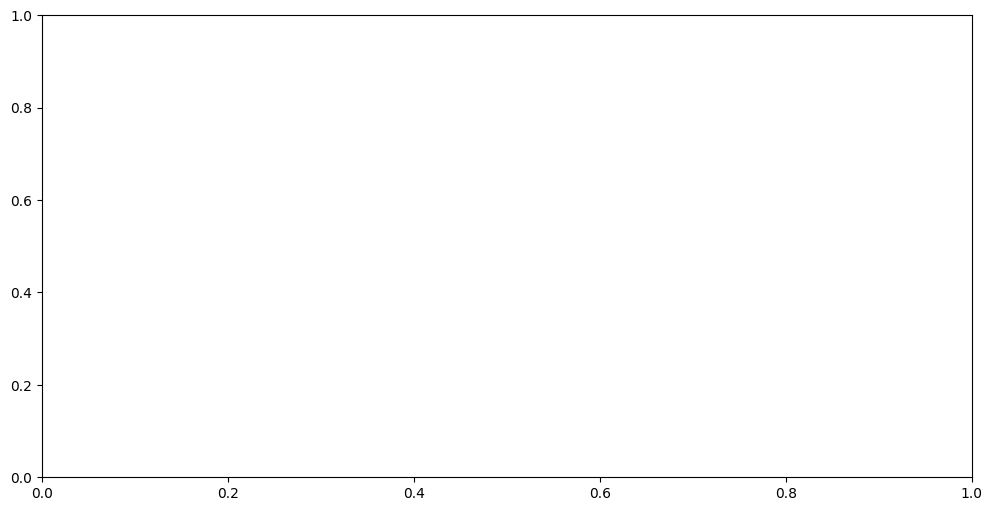

In [31]:
batches_per_epoch = len(train_loader)

# Plotting Training and Validation Loss Over Batches with Epoch Indicators
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(np.linspace(0, len(train_losses), len(val_losses)), val_losses, label='Validation Loss', linestyle='--')
for epoch in range(1, epochs + 1):
    plt.axvline(x=epoch * batches_per_epoch, color='grey', linestyle='--', alpha=0.5)  # Add vertical line for each epoch start
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Batches')
plt.legend()
plt.show()

# Plotting BLEU Score Progression Over Epochs
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), val_bleu_scores, label='Validation BLEU Score', marker='o')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.title('BLEU Score Progression Over Epochs')
plt.legend()
plt.show()

# Plotting Learning Rate Schedule Over Batches with Epoch Indicators
plt.figure(figsize=(12, 6))
plt.plot(lr_rates, label='Learning Rate')
for epoch in range(1, epochs + 1):
    plt.axvline(x=epoch * batches_per_epoch, color='grey', linestyle='--', alpha=0.5)  # Add vertical line for each epoch start
plt.xlabel('Batch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule Over Batches')
plt.yscale('log')  # Use logarithmic scale if learning rates vary widely
plt.legend()
plt.show()


# Assuming val_rouge_scores is a list of dictionaries like [{'rouge1': 0.5, 'rouge2': 0.4, 'rougeL': 0.45}, ...]
rouge1_scores = [score['rouge1'] for score in val_rouge_scores]
rouge2_scores = [score['rouge2'] for score in val_rouge_scores]
rougeL_scores = [score['rougeL'] for score in val_rouge_scores]
epochs = range(1, len(val_rouge_scores) + 1)

# Plotting ROUGE Scores Over Epochs
plt.figure(figsize=(12, 6))
plt.plot(epochs, rouge1_scores, 'bo-', label='ROUGE-1')
plt.plot(epochs, rouge2_scores, 'ro-', label='ROUGE-2')
plt.plot(epochs, rougeL_scores, 'go-', label='ROUGE-L')
plt.xlabel('Epoch')
plt.ylabel('ROUGE Score')
plt.title('ROUGE Scores Progression Over Epochs')
plt.legend()
plt.show()

In [33]:
# Example thematic keywords related to "love" songs
thematic_keywords = ['love', 'heart', 'forever', 'together', 'passion', 'adore', 'warmth', 'embrace', 'hug', 'baby', 'darling']
def thematic_keyword_match(lyrics, keywords):
    """
    Counts the number of thematic keywords present in the generated lyrics.
    """
    matches = sum(1 for word in keywords if word in lyrics.lower())
    return matches

# Example usage with generated lyrics
generated_lyrics = "This love has taken its toll on me, She said goodbye too many times before. I miss you"
matches = thematic_keyword_match(generated_lyrics, thematic_keywords)
print(f"Thematic Keywords Found: {matches} out of {len(thematic_keywords)}")

def evaluate_thematic_content(model, tokenizer, dataloader, device, keywords, max_new_tokens=50):
    """
    Evaluates thematic content by counting thematic keyword matches in generated lyrics.
    :param max_new_tokens: Number of new tokens to generate beyond the input.
    """
    model.eval()
    keyword_matches = []
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader)):
            b_input_ids = batch[0].to(device)
            # Use max_new_tokens to control the number of generated tokens beyond the input
            generated_outputs = model.generate(b_input_ids, max_new_tokens=max_new_tokens)
            for output in generated_outputs:
                lyrics = tokenizer.decode(output, skip_special_tokens=True)
                matches = thematic_keyword_match(lyrics, keywords)
                keyword_matches.append(matches)

    avg_matches = sum(keyword_matches) / len(keyword_matches)
    print(f"Average Thematic Keywords Found: {avg_matches}")
    return avg_matches

# Then, when you call evaluate_thematic_content, specify max_new_tokens as needed:
avg_matches = evaluate_thematic_content(model, tokenizer, test_loader, device, thematic_keywords, max_new_tokens=50)


Thematic Keywords Found: 1 out of 11


  0%|          | 0/13 [00:00<?, ?it/s]<ipython-input-20-8a9ab79a618c>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
  0%|          | 0/13 [00:00<?, ?it/s]


KeyError: 0

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, avg_matches, 'mo-', label='Average Thematic Keyword Matches')
plt.title('Thematic Keyword Match Frequency Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Average Matches')
plt.legend()

plt.show()
